<a href="https://www.kaggle.com/code/marinabalakina/dll30-dz5-ipynb?scriptVersionId=156363142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Домашнее задание к занятию «Улучшение качества обучения нейросети»
**Цель задания:**
научиться использовать в коде различные методы Transfer Learning.

**Задание:**
На примере датасета персонажей мультфильма Симпсонов:
1. Возьмите любую архитектуру (VGG, EfficientNet или MobileNet) и примените к ней методы, которые разбирались на занятии.
2. Модифицируйте код обучения, используя различные типы LR Schedulers из Pytorch. Проведите минимум 2 эксперимента с разными шедулерами.
3. Подберите аугментации train данных, при которых итоговое качество на валидации станет сильно хуже, чем полученное на занятии.
4. Оформите вывод по результатам проведённых экспериментов.

**Формат сдачи работы**

Прикрепите ссылку на готовое решение в личном кабинете. Работу можно отправлять в виде ссылки на python-ноутбук из GitHub, Google Colaboratory или аналогичных платформ. Не забудьте открыть доступ на просмотр и комментирование.

Критерии оценивания
По итогу выполнения задания вы получите - зачёт/незачёт.

**Задание считается выполненным, если:**

* LR Schedulers применяются корректно, проведено 2 эксперимента
* при изменении аугментацией Accuracy сильно (> 10 процентов) уменьшилась
* корректно проведено обучение и дообучение любой сети (VGG, EfficientNet или MobileNet), получены сравнимые результаты или лучше по сравнению с практикой на занятии
* итоговый вывод содержит подробный корректный анализ проведённых экспериментов

**Задание будет отправлено на доработку, если:**

* при встраивании LR шедулеров возникли ошибки/проведено < 2 экспериментов
* не удалось подобрать аугментации, сильно снижающие качество изображений/был выбран совсем тривиальный пример
* не проведены эксперименты с новой архитектурой сети
* вывод не написан/не подробный/содержит фактические ошибки

# Импорт библиотек и пользовательские функции

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v2
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style(style='white')


In [3]:
def check_folder(name):
    folder_contents = os.listdir(name)
    if len(folder_contents) > 0:
        return True
    else:
        return False

In [4]:
# Возможность работы на графическом ускорителе
device = "cuda" if torch.cuda.is_available() else "cpu"
#Размер картинок для resize
input_size = 224
# Размера батча, к-во эпох
batch_size = 64
num_epochs = 10
learning_rate = 0.01
print(device)

cuda


In [5]:
def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

In [6]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [7]:
data_dir = "/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*")

In [9]:
len(data_image_paths)

42

In [10]:
def prepare_datasets(data_dir, train_augmentations=None, val_augmentations=None):
    """аугментация данных происходит в соотвествии с пайплайнами аугментации train_augmentations и val_augmentations"""
    data_paths = glob.glob(f"{data_dir}/*")
    data_image_paths = []
    data_image_labels = []
    for name in data_paths:
        if check_folder(name):
            data_image_paths += glob.glob(f"{name}/*.jpg")
        else:
            print(name)
            os.rmdir(name)
    data_image_labels = [path.split('/')[-2] for path in data_image_paths]
    print(len(data_image_paths), len(data_image_labels))
    train_files_path, val_files_path = train_test_split(
        data_image_paths,
        test_size=0.3,
        stratify=data_image_labels
    )

    print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")
    input_size = 224
    if train_augmentations is not None:
        train_transform = transforms.Compose(train_augmentations)
    else:
        train_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])
    if val_augmentations is not None:
        val_transform = transforms.Compose(val_augmentations)
    else:
        val_transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
        ])

    train_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=train_transform,
          is_valid_file=lambda x: x in train_files_path
      )

    val_dataset = torchvision.datasets.ImageFolder(
          data_dir,
          transform=val_transform,
          is_valid_file=lambda x: x in val_files_path
      )
    return train_dataset, val_dataset

In [11]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    schedulers=None, names=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''
    times = []
    l_rates = []
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)

            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # полностью проходим по валидационному датасету
        for X_batch, y_batch in tqdm(val_batch_gen):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output()
        epoch_time = time.time() - start_time
        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, epoch_time))
        times.append(epoch_time)
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

        plot_learning_curves(history)

        # подключаем шедулер
        if schedulers is not None:
            for scheduler, name in zip(schedulers, names): 
                if name == 'ReduceLROnPlateau':
                    scheduler.step(val_loss)
                else:
                    scheduler.step()
                    l_rates.append(scheduler.get_last_lr())
        else:
            l_rates.append(learning_rate)
    return model, history, times, l_rates

In [12]:
def fine_tuning(schedulers, name):
    fine_tuning_model = nn.Sequential()

    fine_tuning_model.add_module('resnet', torchvision.models.resnet18(pretrained=True))

    # добавим новые слои для классификации для нашей конкретной задачи
    fine_tuning_model.add_module('relu_1', nn.ReLU())
    fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
    fine_tuning_model.add_module('relu_2', nn.ReLU())
    fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

    fine_tuning_model = fine_tuning_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

    clf_model, history, times = train(
      fine_tuning_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, name
    )
    return clf_model, history, times

# 1. Загрузка данных

Все данные теперь находятся в папке data.
Структура трейн данных (simpsons_dataset/) следующая:


-- class_name_0
---- img_0
---- img_1
---- ...
---- img_n
...
-- class_name_k
---- img_0
---- img_1
---- ...
---- img_m

Т.е. название папки -- имя класса (персонажа из Симпсонов), изображения в ней относятся к этому классу.

## 1.1. Подготовка вариантов аугментаций

In [13]:
# Подготовим 3 варианта пайплайнов аугментации для train и val
train_augmentations  = []
val_augmentations = []

# 'Base' - Набор аугментаций, исполоьзованных на занятии для train
train_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ToTensor(),
  ]
# 'Good' - Предполагаемый набор аугментаций для train для улучшения качества модели
train_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ToTensor(),
  ]
# 'Bad' - Предполагаемый набор аугментаций для train для ухудшенния качества модели
train_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.ColorJitter(0.9, 0.9, 0.9),
      transforms.RandomAffine(5),
      transforms.ElasticTransform(alpha=250.0),
      transforms.ToTensor(),
  ]
train_augmentations.append(('Base', train_augmentations_base))
train_augmentations.append(('Good', train_augmentations_good))
train_augmentations.append(('Bad', train_augmentations_bad))

# 'Base' - Набор аугментаций, исполоьзованных на занятии для val
val_augmentations_base = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Good' - Предполагаемый набор аугментаций для val для улучшения качества модели
val_augmentations_good = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
# 'Bad' - Предполагаемый набор аугментаций для val для ухудшения качества модели
val_augmentations_bad = [
      transforms.Resize(input_size),
      transforms.CenterCrop(input_size),
      transforms.ToTensor(),
  ]
val_augmentations.append(('Base', val_augmentations_base))
val_augmentations.append(('Good', val_augmentations_good))
val_augmentations.append(('Bad', val_augmentations_bad))

## 1.2. Подготовка датасетов с минимально необходимыми аугментациями в пайплайне

In [14]:
# Подготовка датасетов с минимально необходимым набором аугментаций
train_dataset, val_dataset = prepare_datasets(data_dir)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


In [16]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


Посмотрим на изображения из val и train

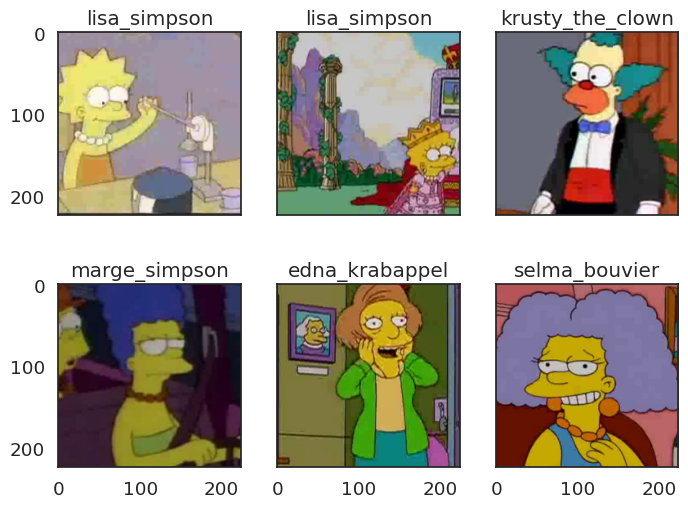

In [17]:
show_images(val_dataset)

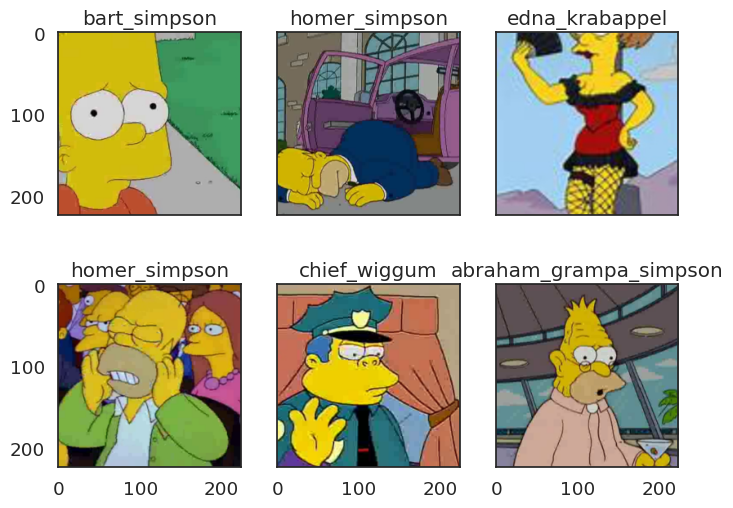

In [18]:
show_images(train_dataset)


Невооруженным взглядом видно, что картинки из `train` принципиально не отличаются от картинок из `val`, т.к. ко всем картинками применялись только операции Resize() И ToTensor()

**Создадим DataLoader-ы и функции для обучения**

In [19]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

# 2. Обучение моделей

In [20]:
df_results = pd.DataFrame(columns=['model','augmentation', 'sheduler','time', 'lr', 'epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy'])

## 2.1. Минимально необходимая аугментация

### 2.1.1 Обучение `ResNet18` с нуля

2.1.1 Обучение ResNet18 с нуля

In [21]:
results = dict()

#### 2.1.1.1. learning_rate = const

Epoch 10 of 10 took 139.518s
  training loss (in-iteration): 	0.612400
  validation loss (in-iteration): 	1.087181
  training accuracy: 			84.21 %
  validation accuracy: 			72.14 %


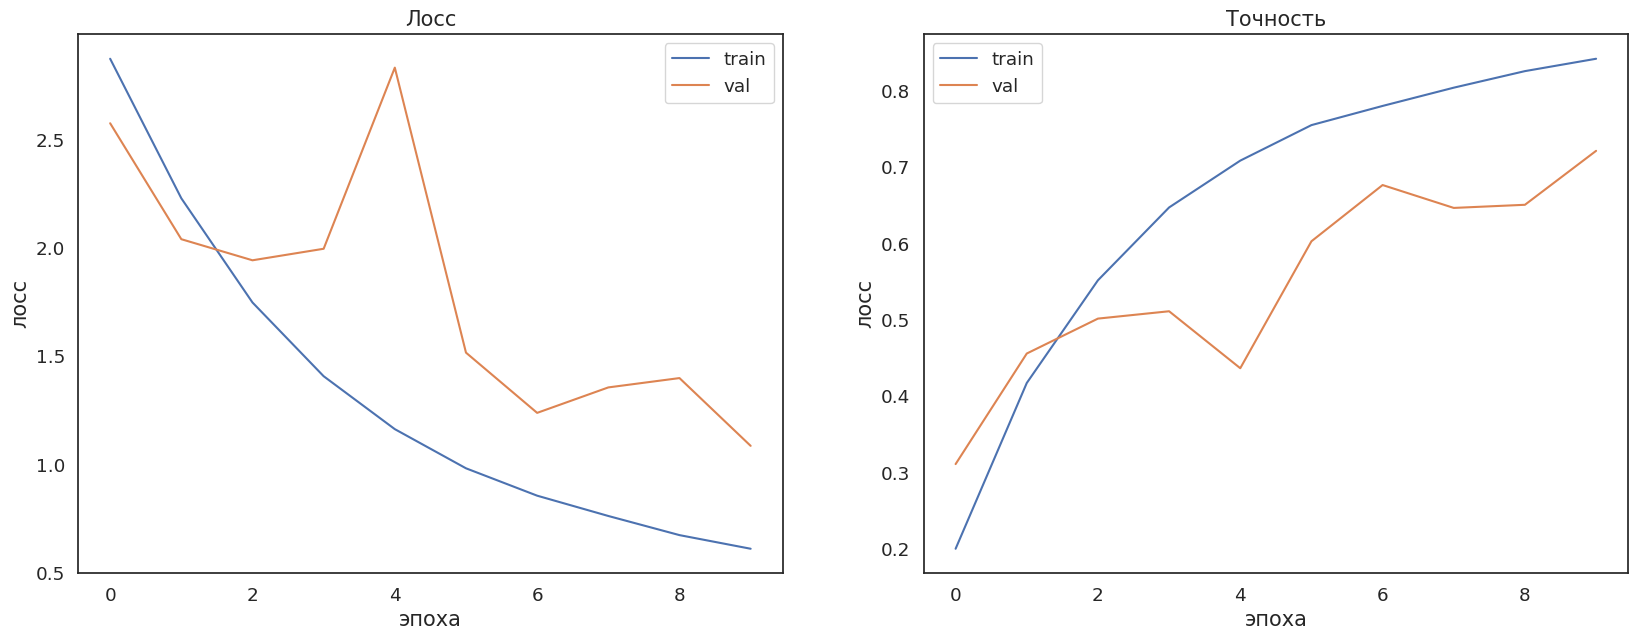

In [22]:
# lr=0.01
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

Модель не доучилась, есть потенциал роста. Думаю, при увеличении шага обучения качество  возрастет

In [23]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]

Гипотеза: При обучении модели с нуля со скоростью 0.01 по кривой обучения для train можно заметить, что за 10 эпох модуль недообучена, потенциал роста Accuracy и снижения loss далеко не исчертпан.Вполне вероятно, что при увеличении числа эпох accuracy на val может опять вырасти, как это произошло в 4 и 7 эпохах. При первоначальном варианте - скорости 0, 01, как это было в примере на лекции, модель за указанное кол-во эпох просто не успеет обучиться до приемлемого уровня качества,поэтому прменение schedulers было бы нецелесообразно  Думаю, что эксперименты с различными schedulers это подтвердят.

In [24]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
5,с нуля,Base,None,142.059045,0.01,5,0.983590,0.755132,1.517249,0.602904
6,с нуля,Base,None,139.797607,0.01,6,0.857296,0.780265,1.239365,0.676610
7,с нуля,Base,None,139.558009,0.01,7,0.763597,0.804204,1.356788,0.646622
8,с нуля,Base,None,139.335842,0.01,8,0.675294,0.825888,1.399874,0.650726
9,с нуля,Base,None,139.517842,0.01,9,0.612400,0.842102,1.087181,0.721433


In [25]:
df_results.to_csv('none.csv', index=False)

#### 2.1.1.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 140.656s
  training loss (in-iteration): 	2.034200
  validation loss (in-iteration): 	2.065079
  training accuracy: 			47.20 %
  validation accuracy: 			47.06 %


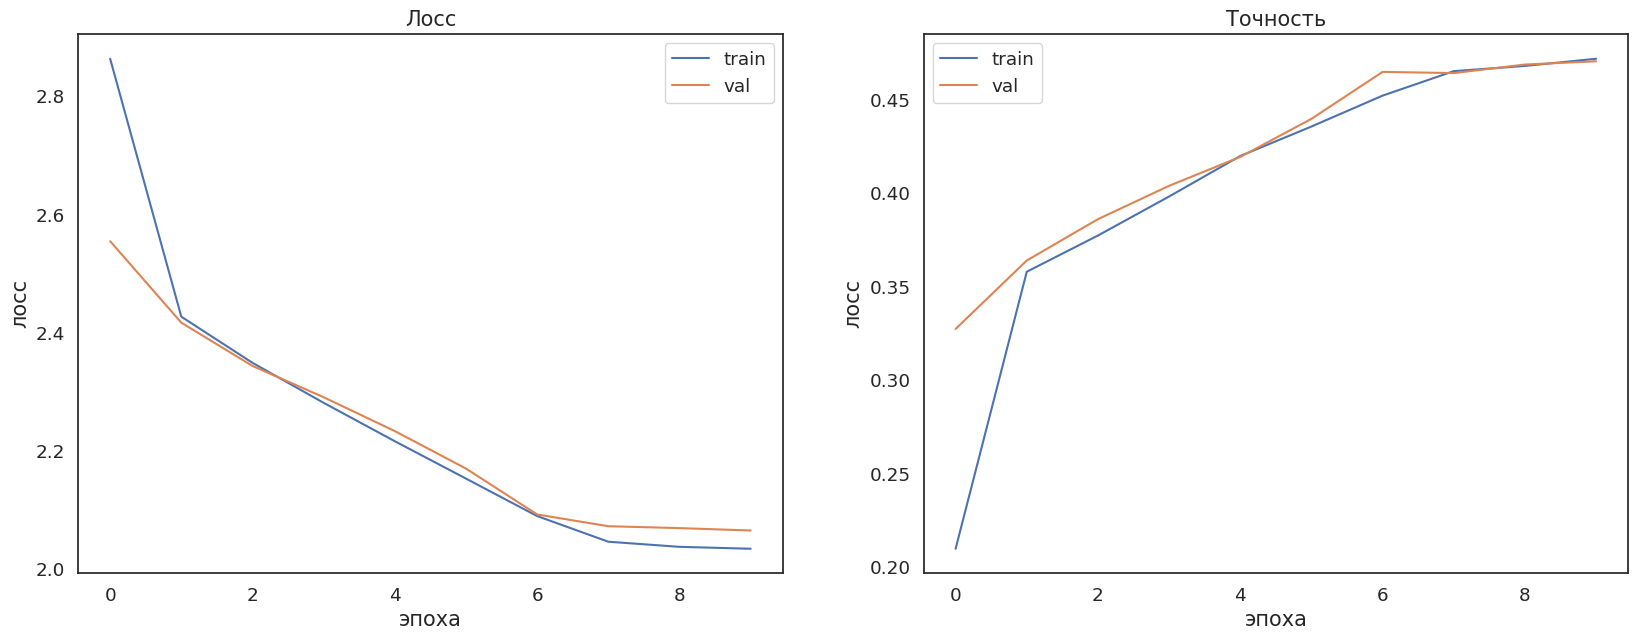

In [34]:
name = 'MultiStep'
names = ['MultiStep']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)

clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [37]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [38]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
5,с нуля,Base,None,142.059045,0.01,5,0.983590,0.755132,1.517249,0.602904
6,с нуля,Base,None,139.797607,0.01,6,0.857296,0.780265,1.239365,0.676610
7,с нуля,Base,None,139.558009,0.01,7,0.763597,0.804204,1.356788,0.646622
8,с нуля,Base,None,139.335842,0.01,8,0.675294,0.825888,1.399874,0.650726
9,с нуля,Base,None,139.517842,0.01,9,0.612400,0.842102,1.087181,0.721433


Качество модели выросло - с 72,14% на тесте при lr= 0.01 до 83,07% на тесте  при использовании Multistep, lr=0.01 до 7 эпохи и 0.001 в 7-10 эпохах. Вполне вероятно, что если после 10 эпохи попробовать еще один шедулер - ReduceLROnPlateau , то можно будет дополнительно повысить качество модели.

In [39]:
df_results.to_csv('multistep.csv', index=False)

#### 2.1.1.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau'

Epoch 10 of 10 took 142.056s
  training loss (in-iteration): 	2.150089
  validation loss (in-iteration): 	2.186774
  training accuracy: 			44.24 %
  validation accuracy: 			43.96 %


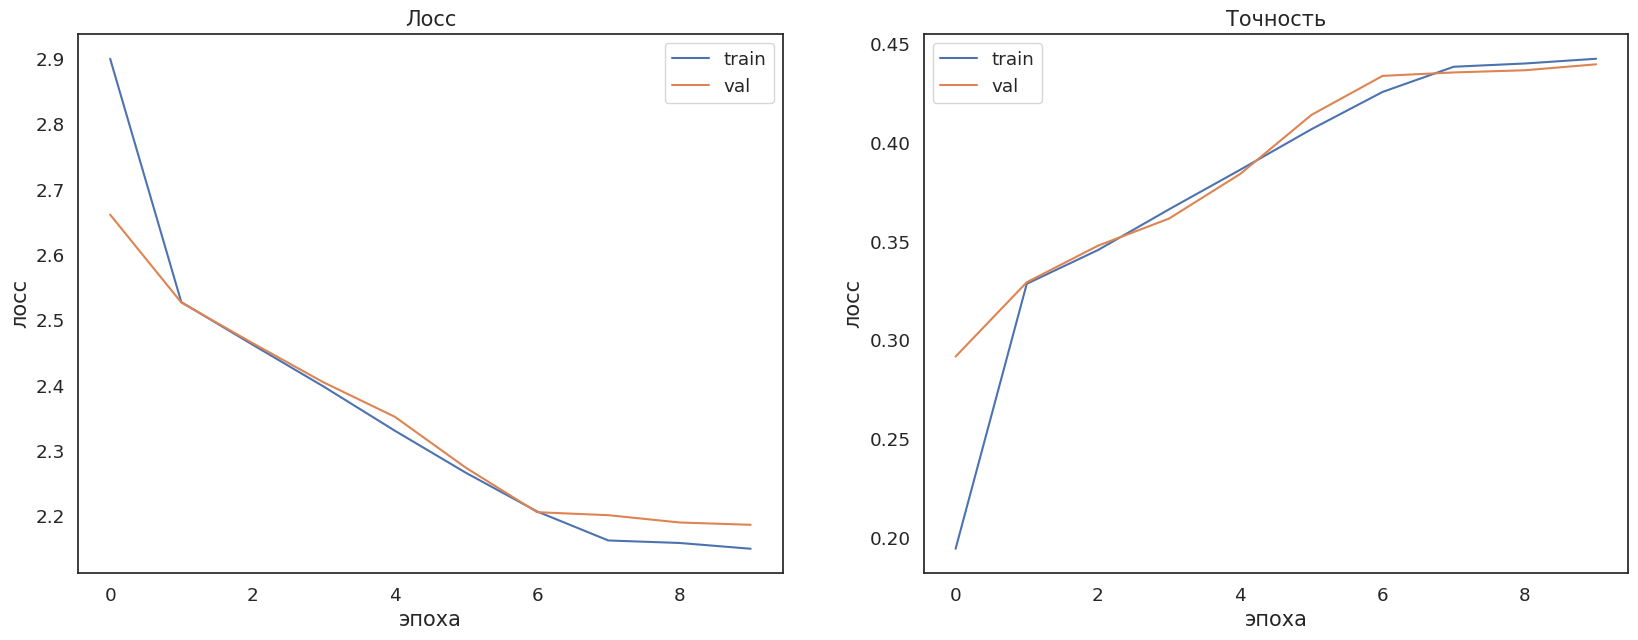

In [40]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
criterion = nn.CrossEntropyLoss()
schedulers = []
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [41]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['с нуля','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [43]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
5,с нуля,Base,None,142.059045,0.01,5,0.983590,0.755132,1.517249,0.602904
6,с нуля,Base,None,139.797607,0.01,6,0.857296,0.780265,1.239365,0.676610
7,с нуля,Base,None,139.558009,0.01,7,0.763597,0.804204,1.356788,0.646622
8,с нуля,Base,None,139.335842,0.01,8,0.675294,0.825888,1.399874,0.650726
9,с нуля,Base,None,139.517842,0.01,9,0.612400,0.842102,1.087181,0.721433


In [44]:
df_results.to_csv('combo1.csv', index=False)

Вывод: в недообученной модели нет никакого смысла использовать шедулеры. Метрики качества обучения при использовании шедулеров существенно хуже, чем при обычном обучении. Если увеличить шаг обучения, шедулеры могут быть полезна

### 2.1.2. ResNet18 как `Feature Extractor`

#### 2.1.2.1. learning_rate = const

In [45]:
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s] 


Epoch 10 of 10 took 115.720s
  training loss (in-iteration): 	1.081144
  validation loss (in-iteration): 	1.143730
  training accuracy: 			74.04 %
  validation accuracy: 			71.70 %


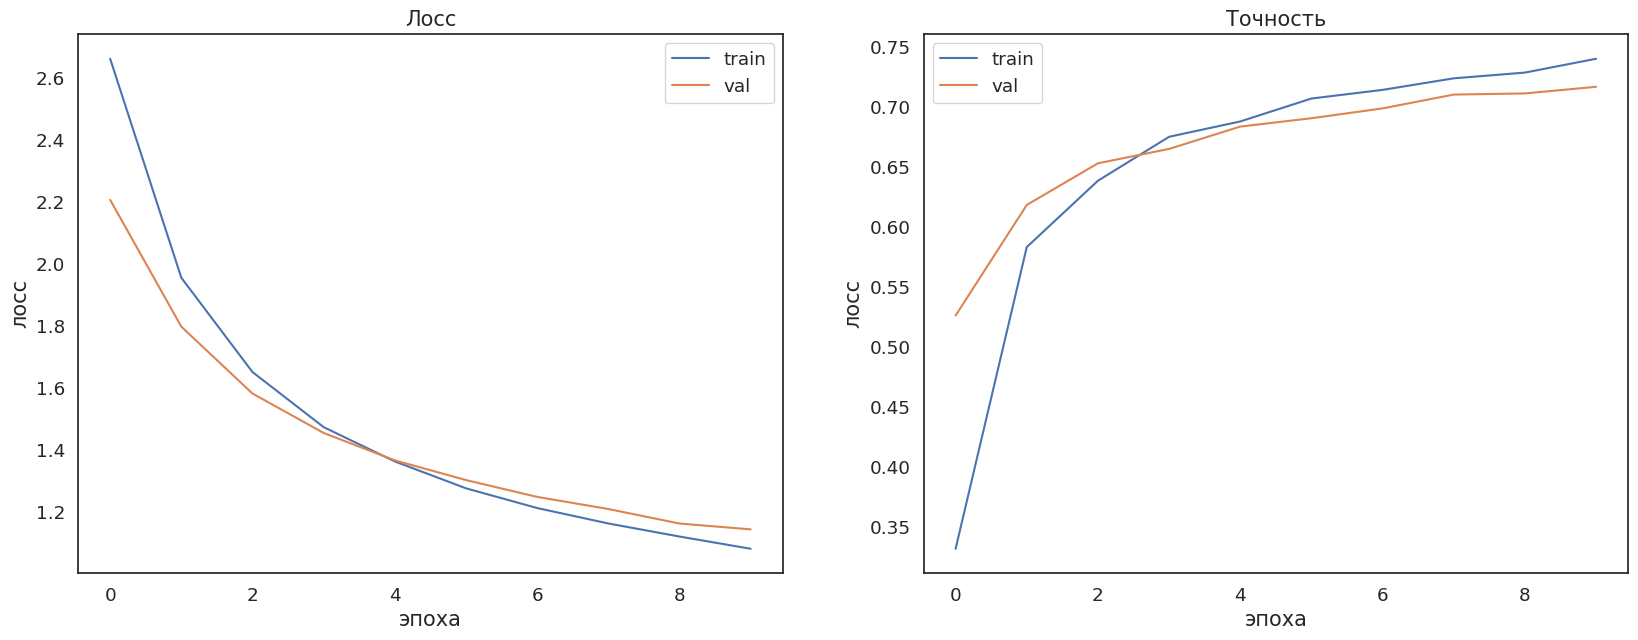

In [46]:
# возьмём предобученную сеть
name = 'None'
# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [50]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', 'None', times[i], l_rates[i], i, results['None']['loss']['train'][i], results['None']['acc']['train'][i], results['None']['loss']['val'][i], results['None']['acc']['val'][i]]

In [51]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
65,feature_extractor,Base,None,116.284490,0.01,5,1.276131,0.707237,1.302769,0.690814
66,feature_extractor,Base,None,115.120398,0.01,6,1.212494,0.714459,1.248443,0.699021
67,feature_extractor,Base,None,116.136873,0.01,7,1.162690,0.724080,1.209416,0.710543
68,feature_extractor,Base,None,114.697599,0.01,8,1.120541,0.728859,1.162469,0.711490


In [49]:
df_results.to_csv('feature_extraction.csv', index=False)

Метрики качества на тесте (71,7%) немного ниже, чем при обучении с нуля (72,14%)

#### 2.1.2.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 119.788s
  training loss (in-iteration): 	1.083166
  validation loss (in-iteration): 	1.147411
  training accuracy: 			73.86 %
  validation accuracy: 			71.20 %


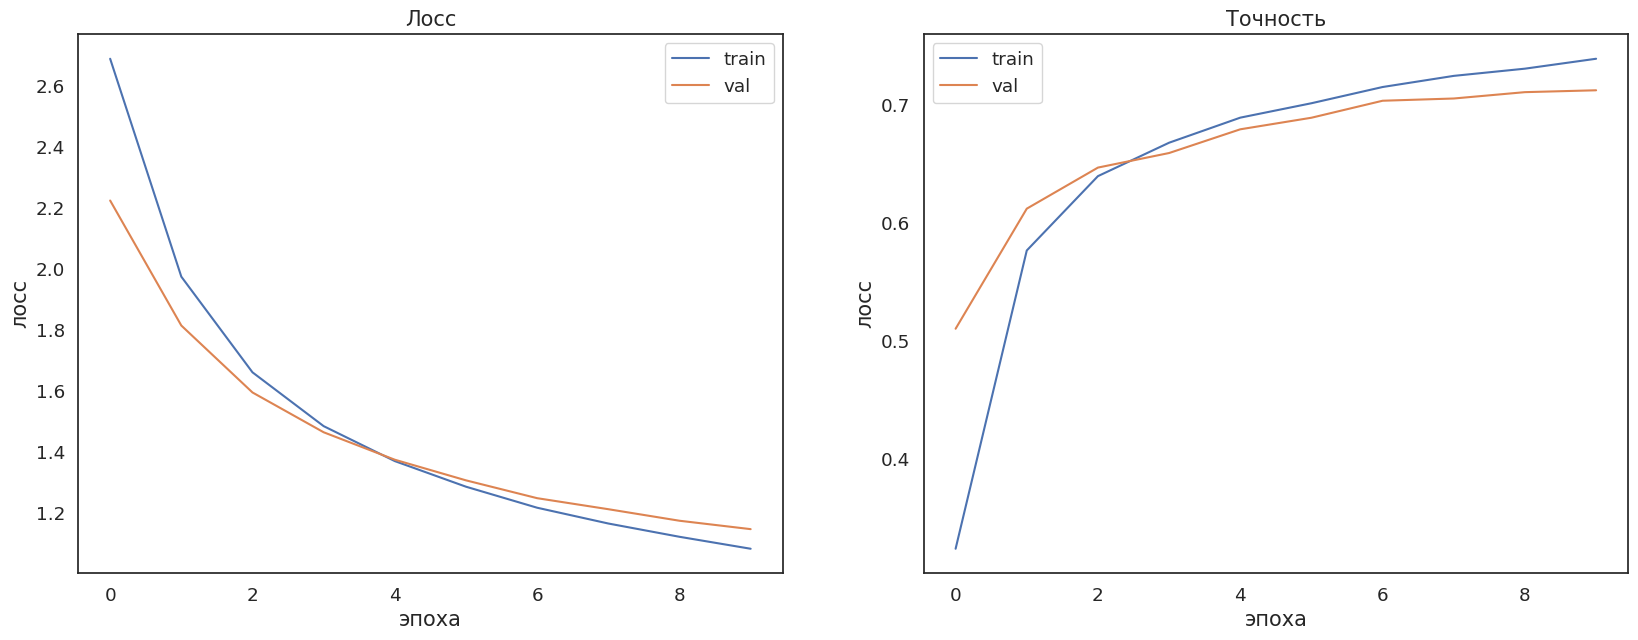

In [52]:
name = 'Multistep'
names = ['MultiStep']
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, schedulers, names
  )
results[name] = history

In [53]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results['None']['loss']['val'][i], results[name]['acc']['val'][i]]

In [54]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
75,feature_extractor,Base,Multistep,115.406916,[0.0001],5,1.286449,0.701014,1.302769,0.688763
76,feature_extractor,Base,Multistep,116.199615,[0.0001],6,1.217566,0.714725,1.248443,0.703125
77,feature_extractor,Base,Multistep,116.871918,[0.0001],7,1.165854,0.724141,1.209416,0.705019
78,feature_extractor,Base,Multistep,118.305824,[0.0001],8,1.122348,0.730234,1.162469,0.710385


In [55]:
df_results.to_csv('feature_extraction_multistep.csv', index=False)

Метрики качества еще несколько упали(71,2% по сравнению с 71,7% в предыдущем эксперименте). Причина - в том, что при использовани шедулера шаг обучения пропорционально снижается, и модель просто не успевает набрать то качество, что при обучении без шедулера, а кривая обучения раньше выходит на насыщение

#### 2.1.2.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau' 

Epoch 10 of 10 took 117.601s
  training loss (in-iteration): 	1.875732
  validation loss (in-iteration): 	1.907007
  training accuracy: 			60.74 %
  validation accuracy: 			59.53 %


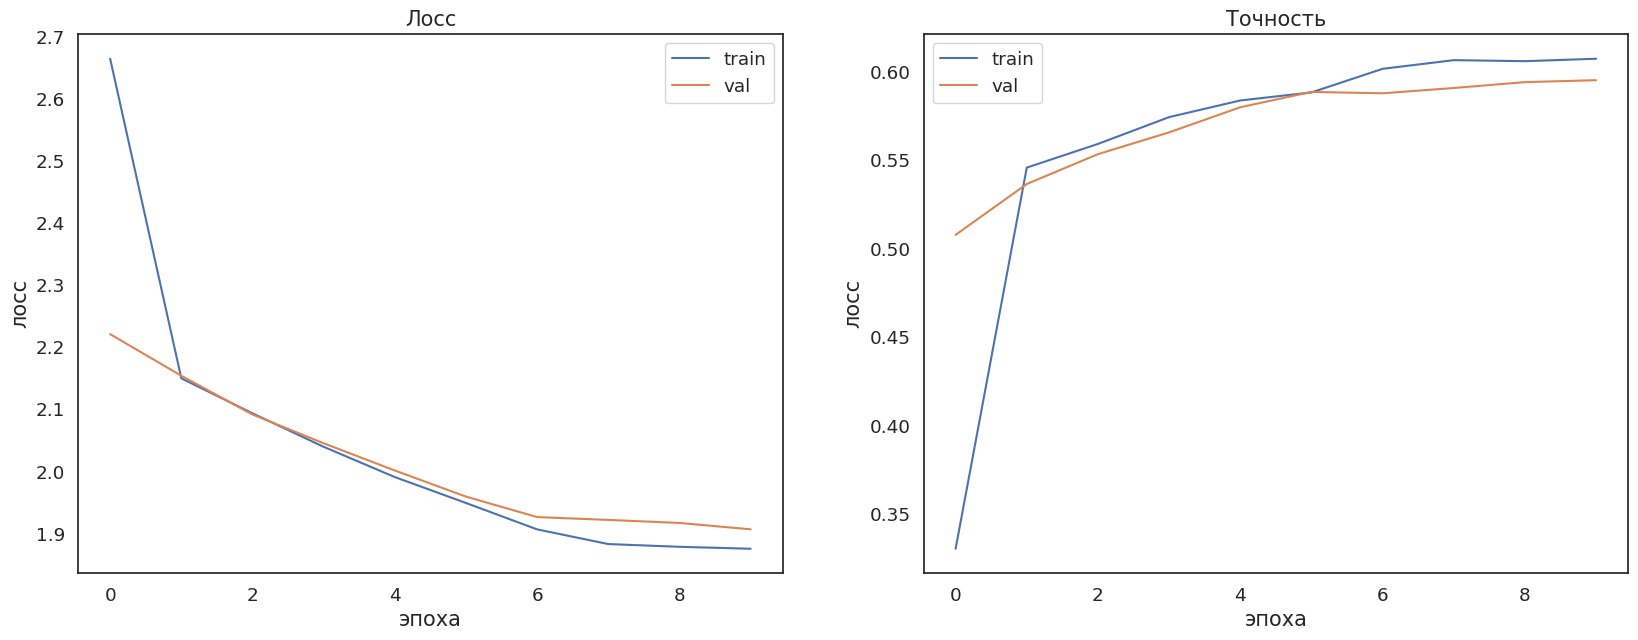

In [56]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
schedulers=[]
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs,  schedulers, names
  )
results[name] = history

In [57]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['feature_extractor','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [58]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
85,feature_extractor,Base,Combo1,116.479521,[0.001],5,1.949390,0.588399,1.959656,0.588699
86,feature_extractor,Base,Combo1,115.496428,[0.0001],6,1.906880,0.601744,1.926694,0.587910
87,feature_extractor,Base,Combo1,115.690996,[0.0001],7,1.883258,0.606650,1.922140,0.590909
88,feature_extractor,Base,Combo1,115.662720,[0.0001],8,1.878878,0.606074,1.917231,0.594223


In [59]:
df_results.to_csv('feature_extraction_combo1.csv', index=False)

Качество стало еще ниже, т.к использование шедулера ReduceLROnPlateau в связке с MultiStepLR приводит к дополнительному снижению шага обучения.

### 2.1.3. `FineTuning`

#### 2.1.3.1. learning_rate = const

Epoch 10 of 10 took 140.911s
  training loss (in-iteration): 	0.018024
  validation loss (in-iteration): 	0.261688
  training accuracy: 			99.82 %
  validation accuracy: 			93.78 %


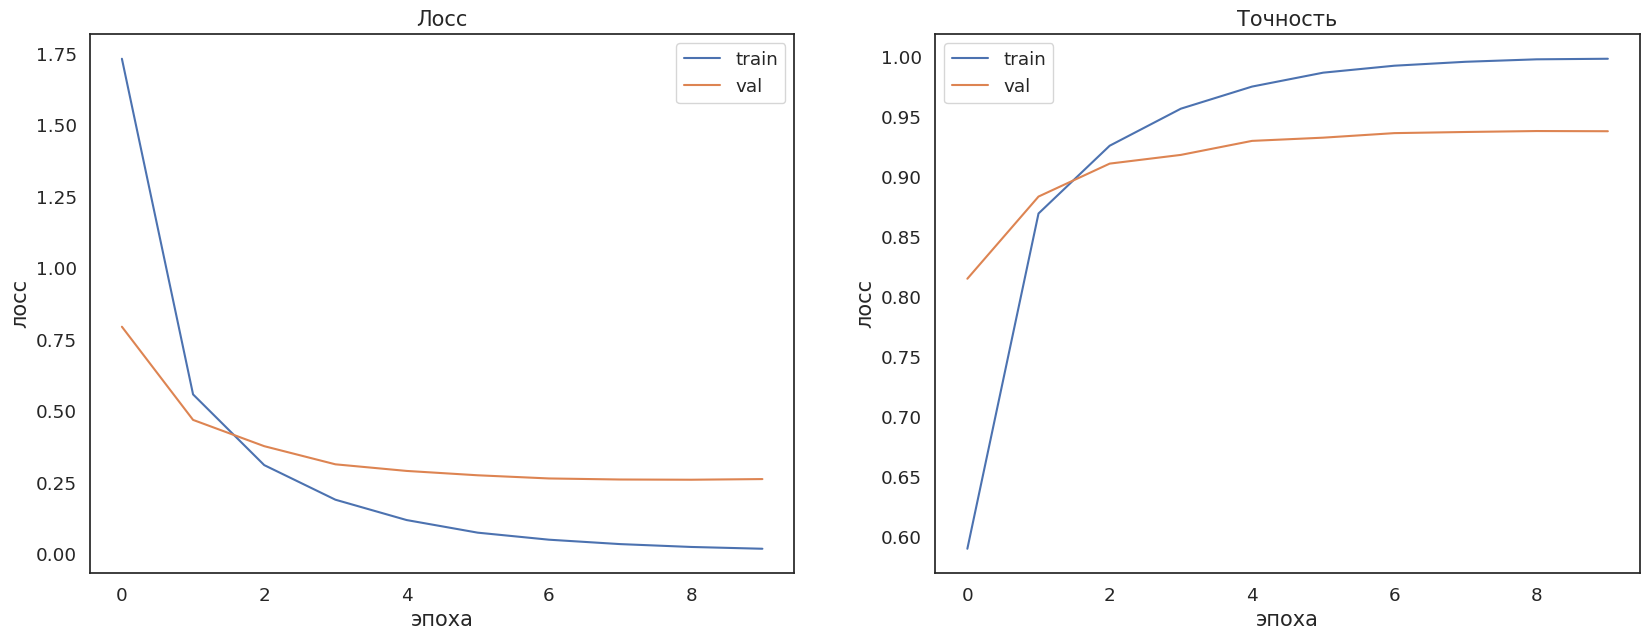

In [60]:
name = 'None'
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10, schedulers=None, names=None
)
results[name] = history

In [61]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [62]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
95,fine_tuning,Base,None,140.282747,0.01,5,0.074280,0.986627,0.274949,0.932449
96,fine_tuning,Base,None,140.524755,0.01,6,0.049705,0.992423,0.263865,0.936237
97,fine_tuning,Base,None,140.678230,0.01,7,0.034289,0.995698,0.260167,0.937184
98,fine_tuning,Base,None,142.247294,0.01,8,0.024291,0.997748,0.259410,0.937973


Лучшее качество модели достигается при FineTuning (93,78% на тесте) по сравнению с 72,14 при обучении с нуля и 71,7% при Feature Extraction. При этом кривая обучения выходит на насыщение начимная с 6 эпохи. Поэтому до 6 эпохи, я думаю, применение шедулеров, уменьшающих шаг обучения, нецелесообразно

#### 2.1.3.2. Learning Rate Scheduler = 'Multistep'

Epoch 10 of 10 took 140.485s
  training loss (in-iteration): 	0.441474
  validation loss (in-iteration): 	0.549348
  training accuracy: 			89.73 %
  validation accuracy: 			86.52 %


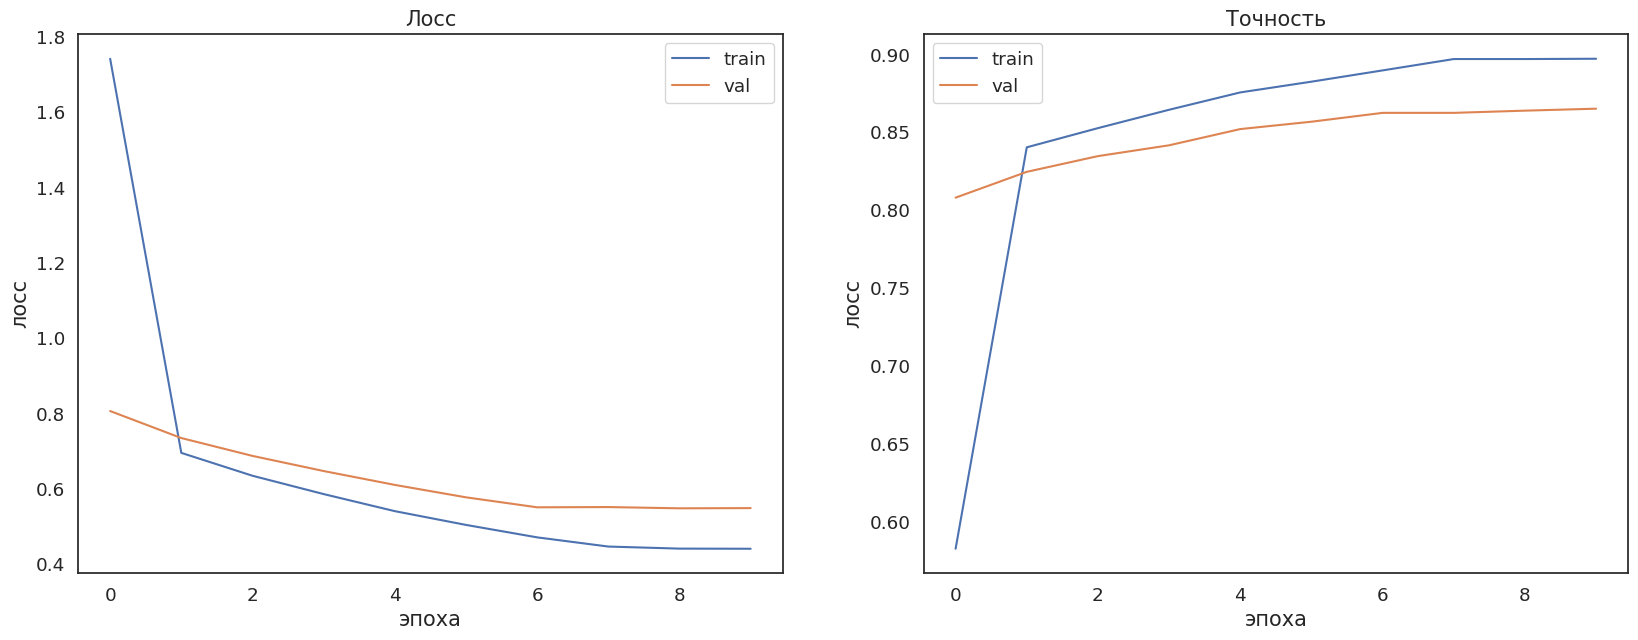

In [64]:
name = 'Multistep'
names = ['Multistep']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
schedulers =[]
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs, schedulers, names
)
results[name] = history

In [70]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

Как и предполагалось,применение шедулера с начала обучения не привело к росту качества модели (86,52% на тесте по сравнению с 93,78% без использования шедулера)

In [65]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
95,fine_tuning,Base,None,140.282747,0.01,5,0.074280,0.986627,0.274949,0.932449
96,fine_tuning,Base,None,140.524755,0.01,6,0.049705,0.992423,0.263865,0.936237
97,fine_tuning,Base,None,140.678230,0.01,7,0.034289,0.995698,0.260167,0.937184
98,fine_tuning,Base,None,142.247294,0.01,8,0.024291,0.997748,0.259410,0.937973


In [71]:
df_results.to_csv('fine_tuning_multistep.csv', index=False)

#### 2.1.3.3. Learning Rate Scheduler = 'Multistep' + 'ReduceLROnPlateau'

Epoch 10 of 10 took 141.498s
  training loss (in-iteration): 	0.017574
  validation loss (in-iteration): 	0.247847
  training accuracy: 			99.89 %
  validation accuracy: 			94.29 %


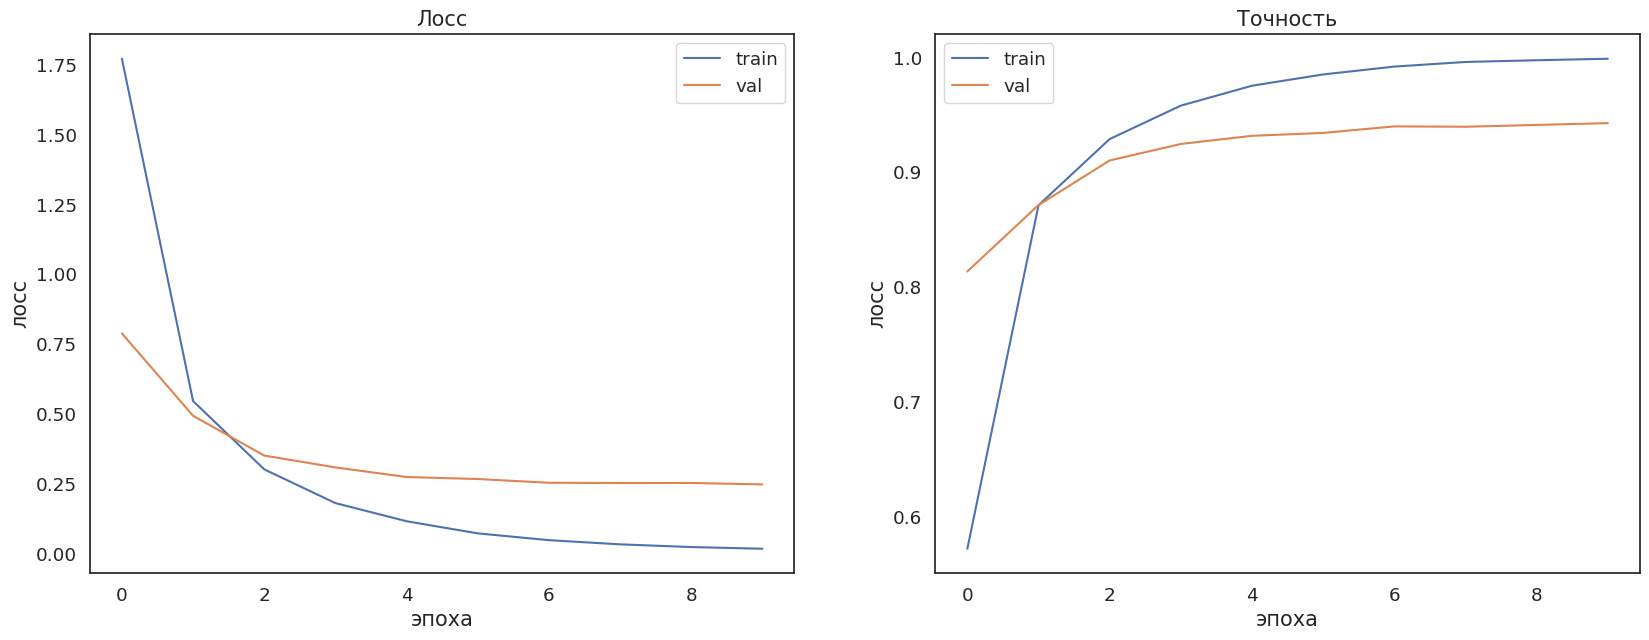

In [66]:
name = 'Combo1'
names = ['MultiStep', 'ReduceLROnPlateau']
fine_tuning_model = nn.Sequential()
fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler1 =  torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[1,7], gamma=0.1)
schedulers.append(scheduler1)
scheduler2 =   ReduceLROnPlateau(optimizer, 'min',factor=0.95, patience=3,
                                threshold=0.001, min_lr=0.0001, verbose=True)
schedulers.append(scheduler2)
clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs, schedulers, names
)
results[name] = history

In [67]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','Base', name, times[i], l_rates[i], i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]

In [68]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
105,fine_tuning,Base,Combo1,145.140154,[0.0001],5,0.072618,0.985255,0.267136,0.934343
106,fine_tuning,Base,Combo1,143.928908,[0.0001],6,0.048296,0.992085,0.253750,0.940025
107,fine_tuning,Base,Combo1,142.575481,[0.0001],7,0.033327,0.996111,0.252777,0.939710
108,fine_tuning,Base,Combo1,140.387224,[0.0001],8,0.023673,0.997612,0.253048,0.941288


In [ ]:
А вот в последнем случае применение комбинации шедулеров (multiStepLR + ReduceLROnPlateau) напротив, позволило незначительно повысить качество модели из-за появления плато на кривой обучения начиная с 6 эпохи(хотя я думаю, что применение только ReduceLROnPlateau начиная с 6 эпохи сработало бы еще лучше)

In [69]:
df_results.to_csv('fine_tuning_combo1.csv', index=False)

## 2.3. Предположительно "Хорошая" аугментация

In [72]:
# Подготовка датасетов с предположительно хорошей аугментацией
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_good,val_augmentations_good)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


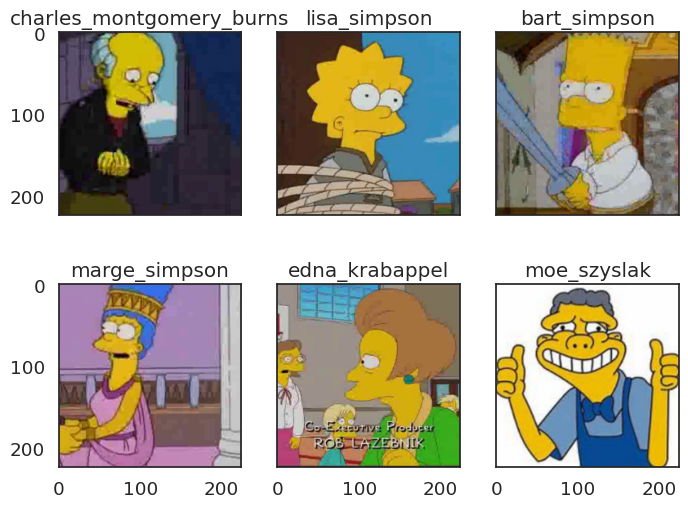

In [73]:
show_images(val_dataset)

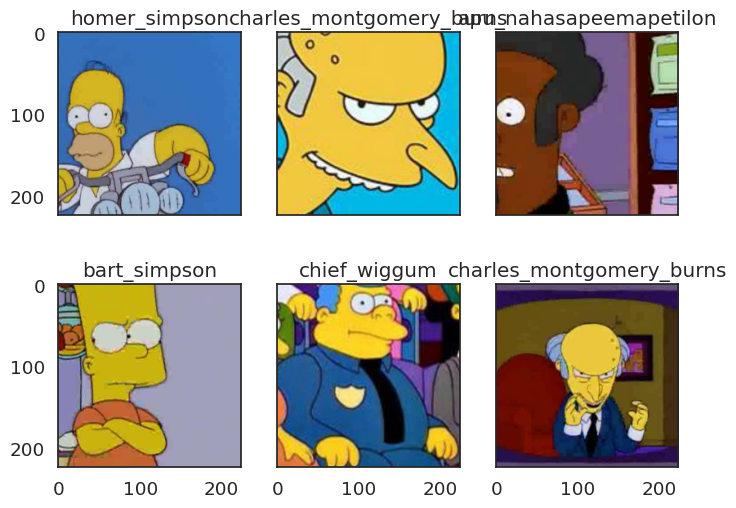

In [74]:
show_images(train_dataset)

Вывод: "Хорошая" аугментация - это усовершенствованная базовая, из которой убраны лишние опции (       transforms.ColorJitter(0.9, 0.9, 0.9) и  transforms.RandomAffine(5), и добавлены те, что позволят повысить обобщающую способность модели благодаря разнообразию изображений, близко соотвествующих исходной серии (transforms.RandomHorizontalFlip(p=0.5)

In [75]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### 2.3.1. Обучение с нуля

Epoch 10 of 10 took 142.816s
  training loss (in-iteration): 	0.698884
  validation loss (in-iteration): 	0.912030
  training accuracy: 			82.07 %
  validation accuracy: 			75.98 %


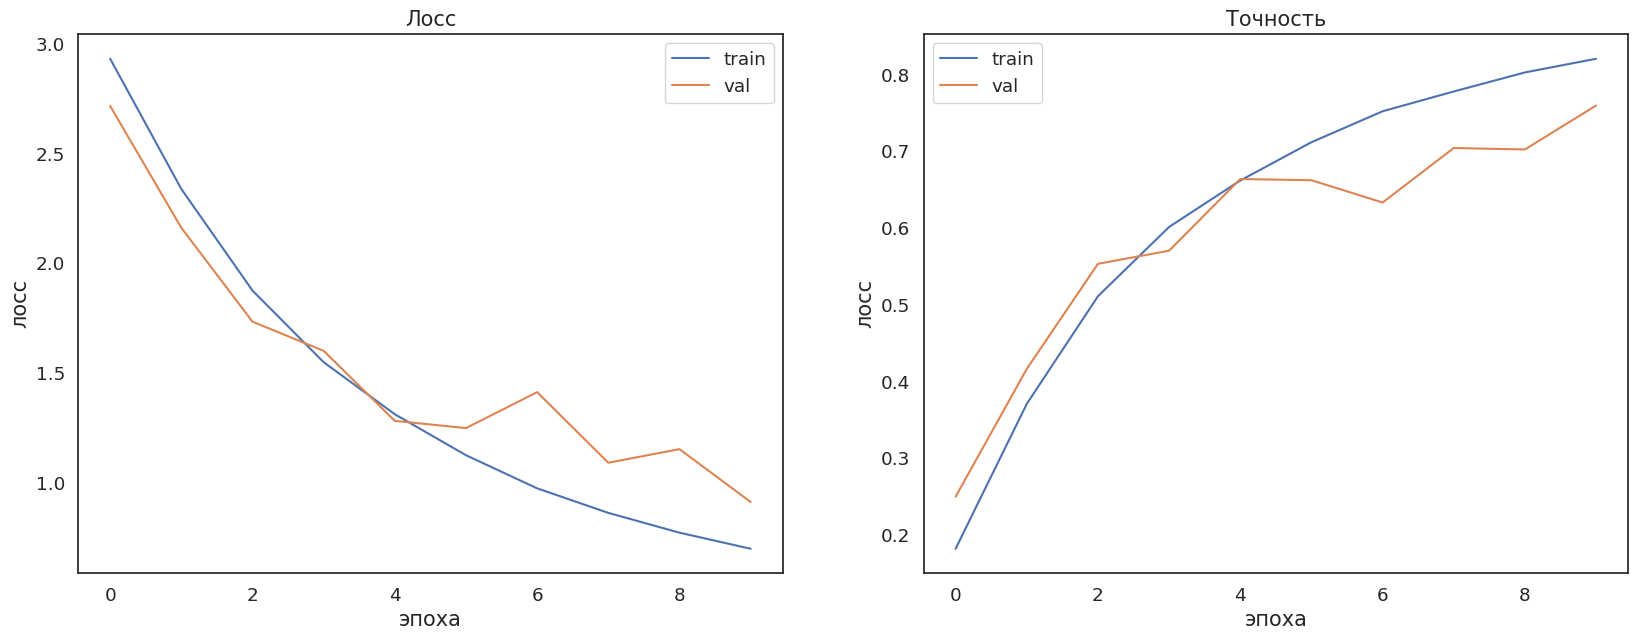

In [79]:
criterion = nn.CrossEntropyLoss()
name='None'
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      10, None, None
  )
results['None'] = history

In [81]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['С нуля','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


В целом при использовании "хорошей" аугментации модель показала результаты примерно на 2% лучше,, чем при использовании базовых (лекционных) аугментаций ( 45,98% против 72,14% на тесте )

In [82]:
df_results.to_csv('good.csv', index=False)

### 2.3.2. Feature Extraction

Epoch 10 of 10 took 115.094s
  training loss (in-iteration): 	1.098339
  validation loss (in-iteration): 	1.165562
  training accuracy: 			73.39 %
  validation accuracy: 			71.18 %


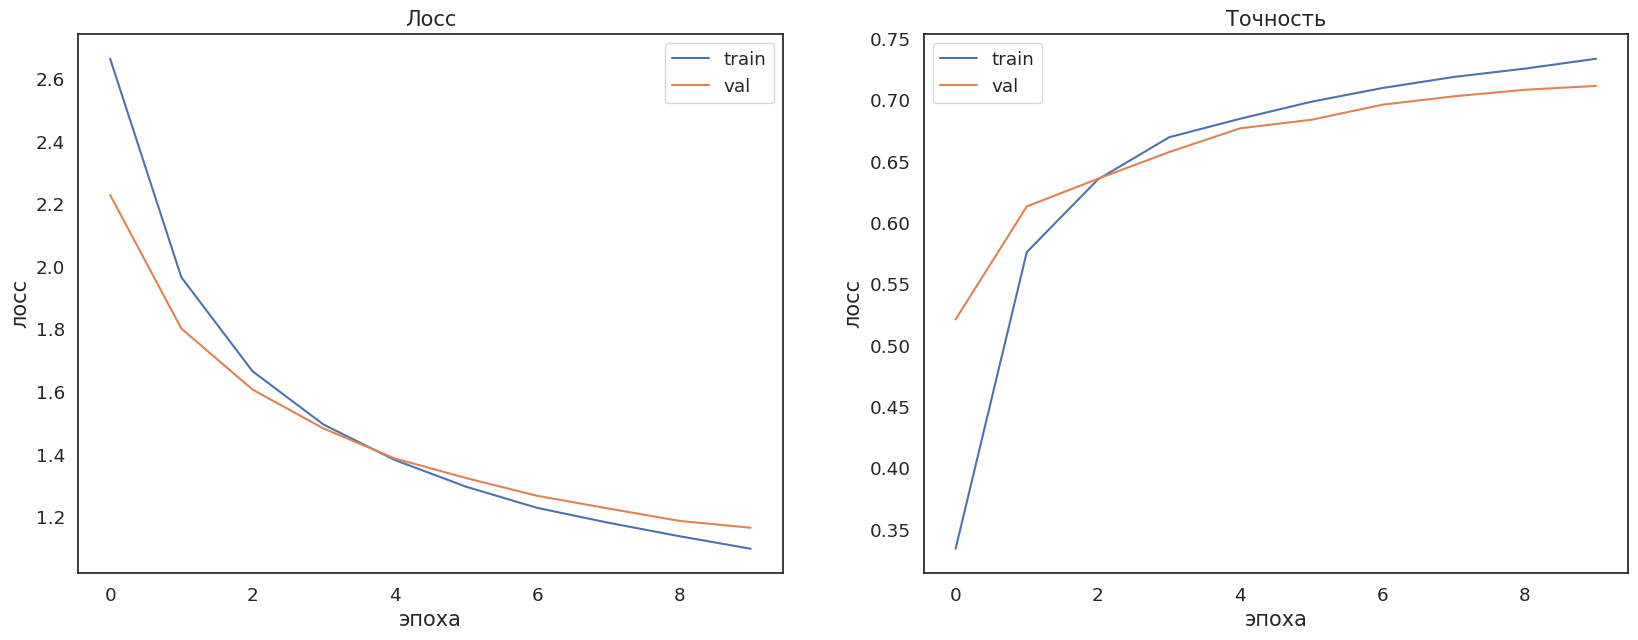

In [83]:
# возьмём предобученную сеть
name = 'None'
fe_model = torchvision.models.resnet18(pretrained=True)
# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )
results[name] = history

In [84]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['features_extraction','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [85]:
df_results.to_csv('features_extraction_good.csv', index=False)

Модель при использовании хорошей аугментации и feature_extraction позволила получить accuracy на тесте 71,18%, что примерно соответсвует accuracy в базовой аугментации.

### 2.3.3. Fine tuning

Epoch 10 of 10 took 142.427s
  training loss (in-iteration): 	0.035856
  validation loss (in-iteration): 	0.218801
  training accuracy: 			99.37 %
  validation accuracy: 			95.28 %


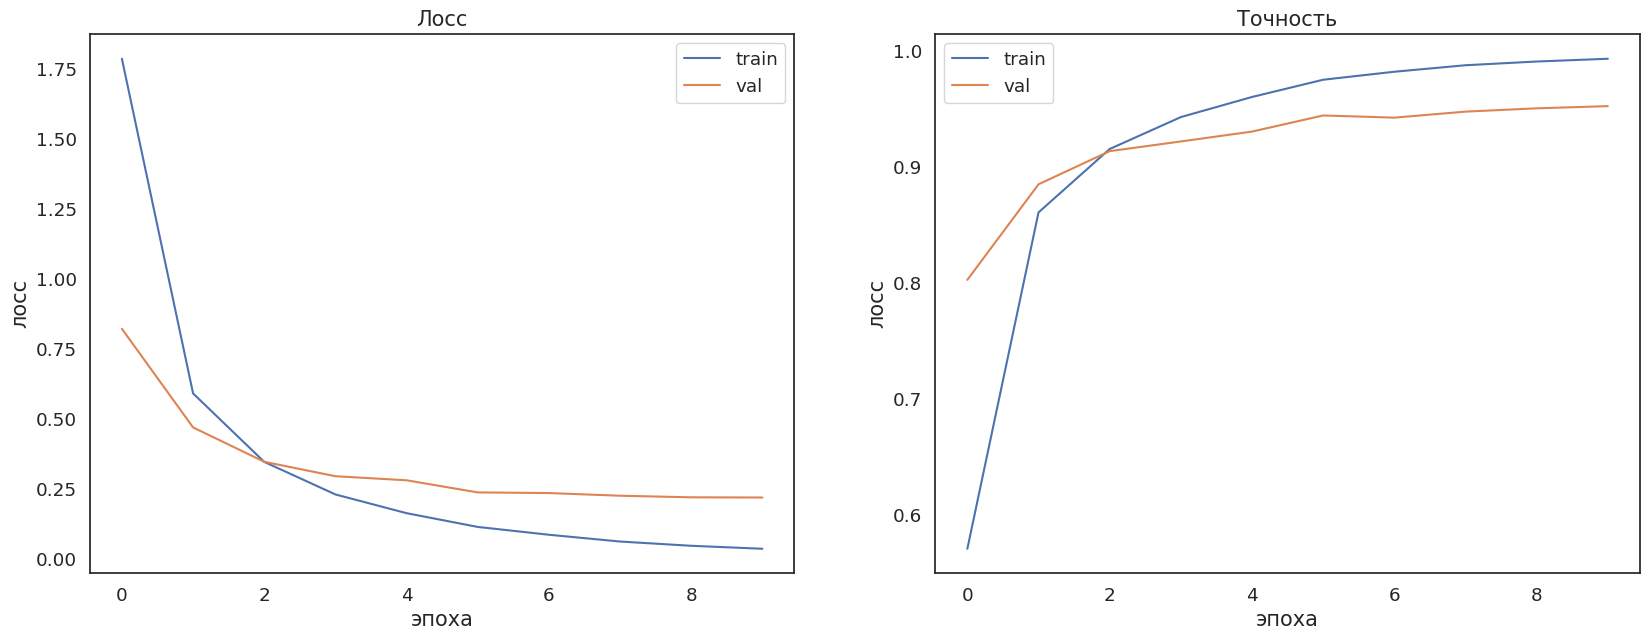

In [86]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    10, None, None
)
results[name] = history

In [87]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','good', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [88]:
df_results.to_csv('fine_tuning_good.csv', index=False)

При использовании "хорошей" аугментации качество модели выше примерно но 1% по сравнению с базовой (95,28% против 94,29% на тесте)

## 2.4. Предположительно "Плохая" аугментация

In [89]:
# Подготовка датасетов с предположительно плохой аугментацией
train_dataset, val_dataset = prepare_datasets(data_dir, train_augmentations_bad,val_augmentations_bad)

20933 20933
Изображений в train: 14653
Изображений в val: 6280


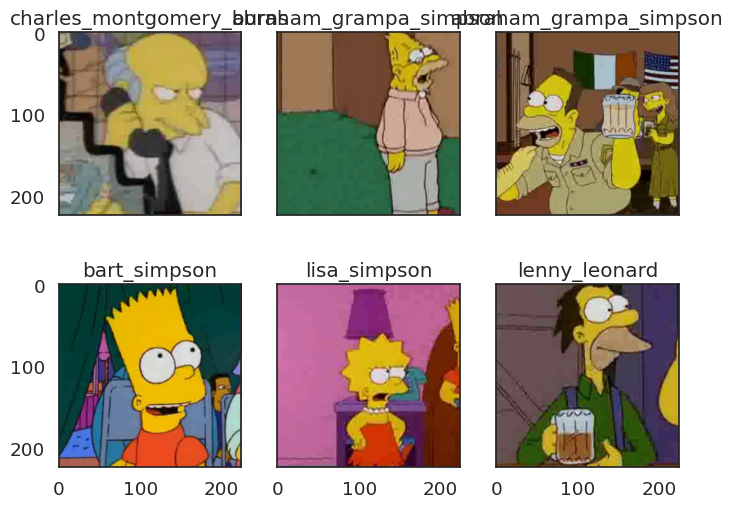

In [90]:
show_images(val_dataset)

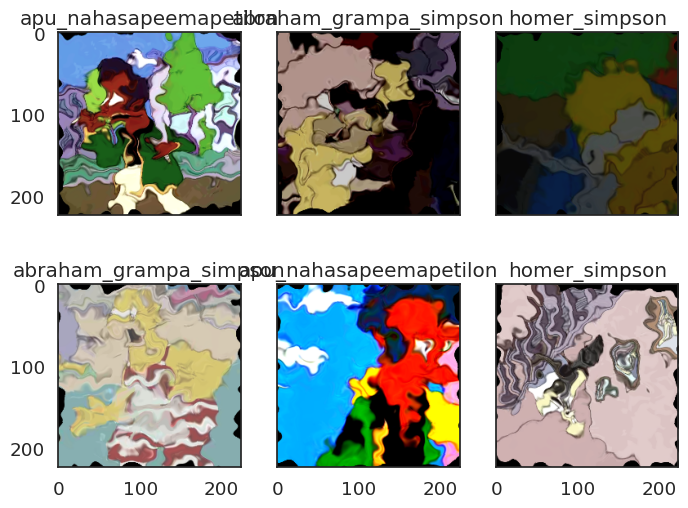

In [91]:
show_images(train_dataset)

In [92]:
# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### 2.4.1. Обучение с нуля

Epoch 10 of 10 took 617.481s
  training loss (in-iteration): 	2.286276
  validation loss (in-iteration): 	2.050686
  training accuracy: 			36.03 %
  validation accuracy: 			43.94 %


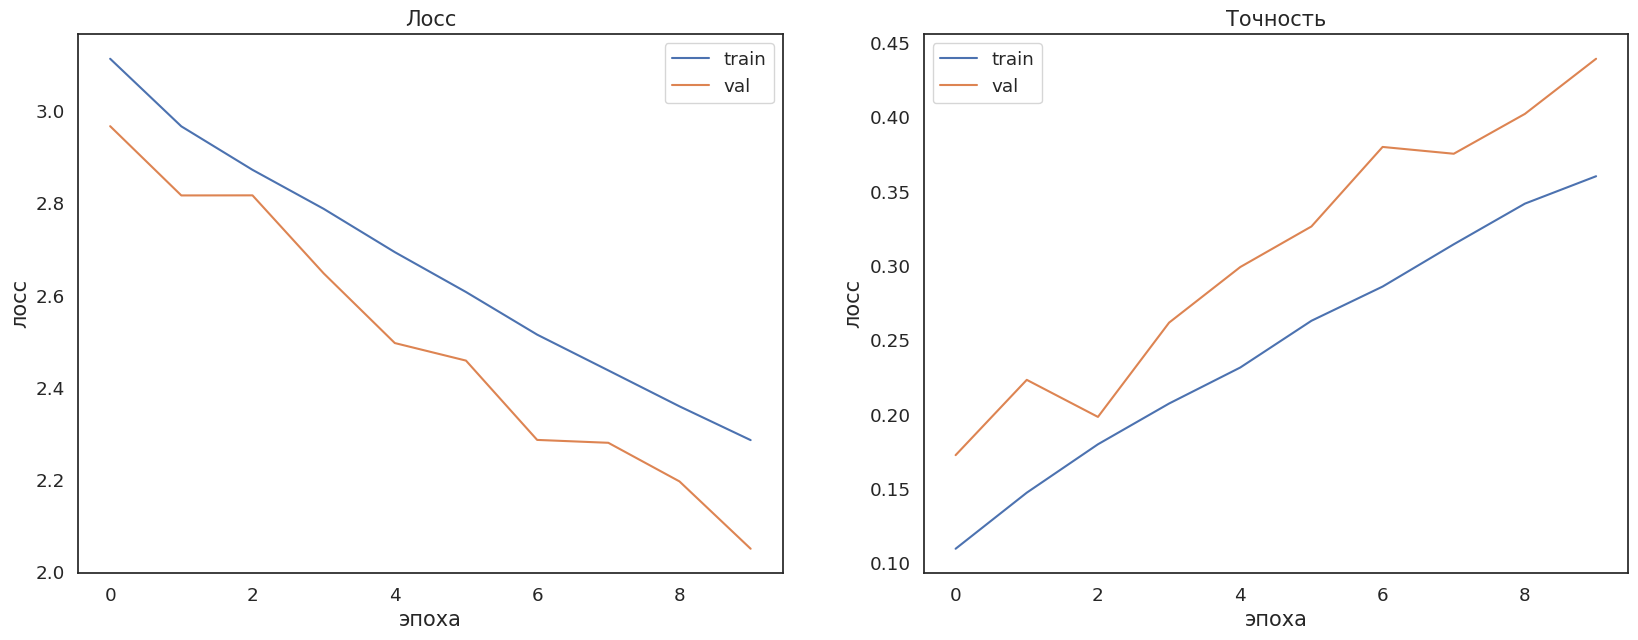

In [95]:
criterion = nn.CrossEntropyLoss()
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
clf_model, history,  times, l_rates = train(
      model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None
  )
results['None'] = history

In [96]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['С нуля','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [97]:
df_results.to_csv('bad.csv', index=False)

Применение неудачных опций при аугментации данных самым пагубным образом сказывается на качестве модели и сильно увеличивает время ее обучения. В частности, использование таких опций, как   transforms.RandomVerticalFlip(p=0.5), transforms.ColorJitter(0.9, 0.9, 0.9),
transforms.RandomAffine(5), transforms.ElasticTransform(alpha=250.0), приводит к преобразованию изображений в далекие от реальности образцы, что привело к снижению accuracy на тесте с 72,14% до 43,94%

### 2.4.2. Feature Extraction

In [98]:
# возьмём предобученную сеть
fe_model = torchvision.models.resnet18(pretrained=True)

Epoch 10 of 10 took 580.084s
  training loss (in-iteration): 	2.556138
  validation loss (in-iteration): 	2.827562
  training accuracy: 			29.04 %
  validation accuracy: 			19.35 %


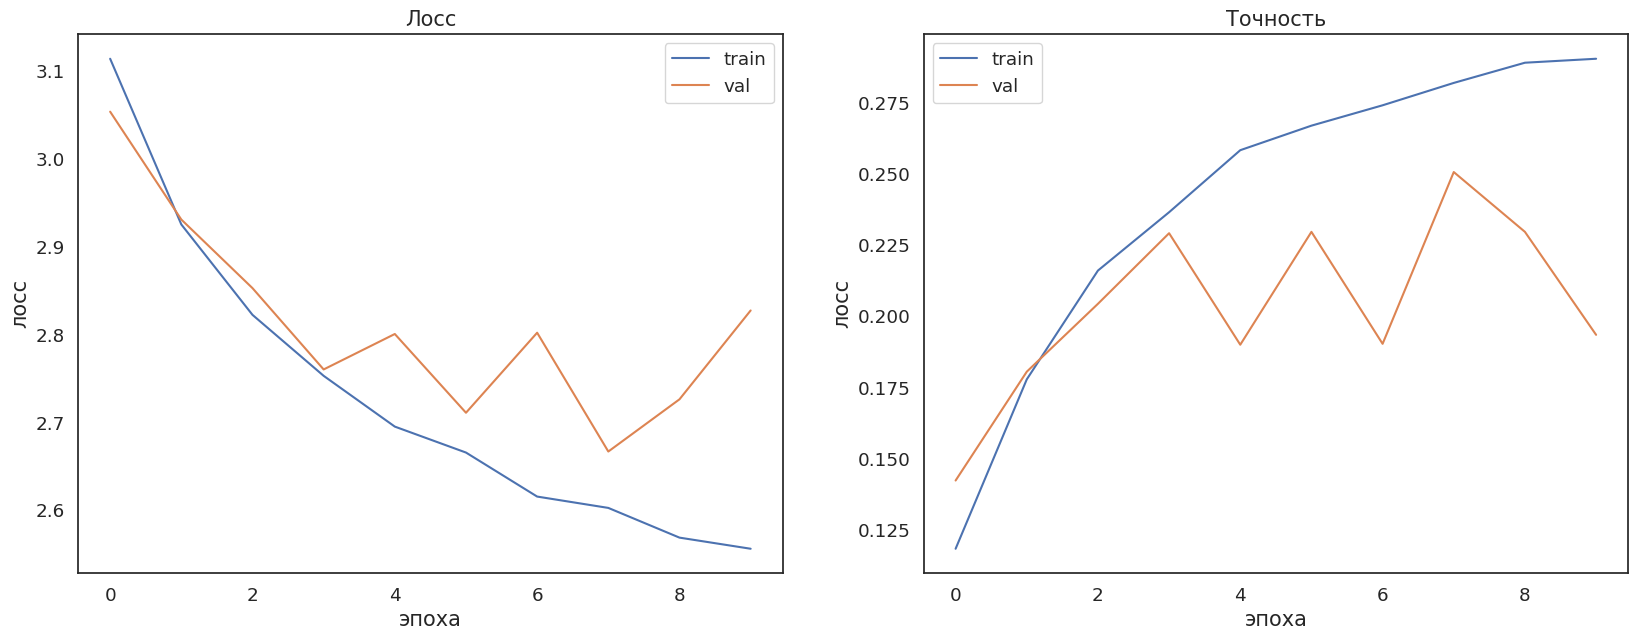

In [99]:

name = 'None'

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=learning_rate)

clf_model, history, times, l_rates = train(
      fe_model, criterion, optimizer,
      train_batch_gen, val_batch_gen,
      num_epochs, None, None
  )


In [100]:
results[name] = history

In [101]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['features_extraction','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [ ]:
df_results.to_csv('feature_extraction_bad.csv', index=False)

Вывод: при использовании неудачных вариантов аугментации качество модели серьезно ухудшилось (27,10% против 76,22% На тестовых данных при использовании Feature extraction)

### 2.4.3. Fine tuning

Epoch 10 of 10 took 593.815s
  training loss (in-iteration): 	0.495265
  validation loss (in-iteration): 	0.488000
  training accuracy: 			86.69 %
  validation accuracy: 			86.81 %


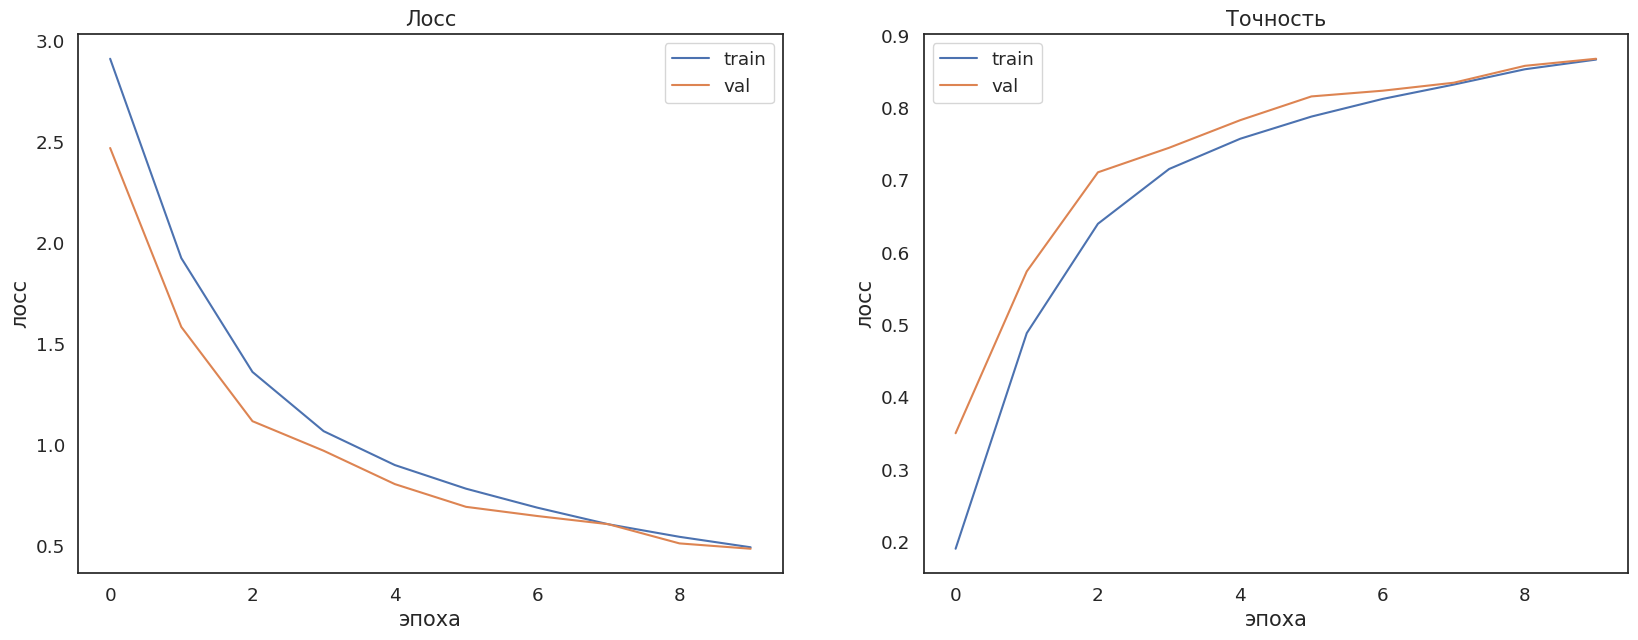

In [102]:
name='None'
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet',  torchvision.models.resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history, times, l_rates = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    10, None, None
)

In [103]:
for i in range(10):
    df_results.loc[len(df_results.index)] = ['fine_tuning','bad', name, times[i], learning_rate, i, results[name]['loss']['train'][i], results[name]['acc']['train'][i], results[name]['loss']['val'][i], results[name]['acc']['val'][i]]


In [104]:
df_results

,model,augmentation,sheduler,time,lr,epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,с нуля,Base,None,267.864162,0.01,0,2.873252,0.199982,2.575637,0.310922
1,с нуля,Base,None,140.857679,0.01,1,2.229409,0.417210,2.040682,0.455808
2,с нуля,Base,None,142.063044,0.01,2,1.748658,0.551789,1.943337,0.501578
3,с нуля,Base,None,142.682200,0.01,3,1.408464,0.647241,1.996519,0.511206
4,с нуля,Base,None,140.123212,0.01,4,1.164262,0.708598,2.832264,0.436553
...,...,...,...,...,...,...,...,...,...,...
175,fine_tuning,bad,None,616.409447,0.01,5,2.665713,0.266917,2.711047,0.229640
176,fine_tuning,bad,None,609.988299,0.01,6,2.615574,0.274064,2.802213,0.190341
177,fine_tuning,bad,None,613.365337,0.01,7,2.602653,0.281918,2.666879,0.250631
178,fine_tuning,bad,None,603.711263,0.01,8,2.568806,0.289010,2.726353,0.229640


In [105]:
df_results.to_csv('all_results.csv', index=False)

Вывод: при использовании тонкой настройки и различных вариантов аугментаций разница в качестве не столь велика, как при feature_extraction (accuracy на тесте при базовой аугментации 94,62%, при хорошей аугментации - 95,31%, при плохой - 86,81% ( почти на 10% меньше)